In [1]:
# Library to support working with data
import pandas as pd
import numpy as np

# Data Normalization Support Library
from sklearn.preprocessing import MinMaxScaler

# Training model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.neural_network import MLPRegressor

# Performance metrics calculation support library
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

# Graphing support library
from matplotlib import ticker
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/admin/Documents/HK5 2025-2026/PTDLKD IS403.Q12/DoAn/Dataset/Apple_clean.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-12-31,7.611786,7.619643,7.520000,7.526071,6.326138,352410800
1,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.424604,493729600
2,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.435713,601904800
3,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.333343,552160000
4,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.321635,477131200
...,...,...,...,...,...,...,...
3977,2025-10-23,259.940002,260.619995,258.010010,259.579987,259.579987,32754900
3978,2025-10-24,261.190002,264.130005,259.179993,262.820007,262.820007,38253700
3979,2025-10-27,264.880005,269.119995,264.649994,268.809998,268.809998,44888200
3980,2025-10-28,268.989990,269.890015,268.149994,269.000000,269.000000,41461500


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select 'Close' column
df_Close = df[['Close']]
df_Close = df_Close.reset_index(drop=True)

In [5]:
# Scaler data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(np.array(df_Close))

In [6]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(len(df_scaled) * 0.6)
val_size = int(len(df_scaled) * 0.2)
test_size = len(df_scaled) - train_size - val_size

train_data = df_scaled[0 : train_size, :]
val_data = df_scaled[train_size : train_size + val_size, :]
test_data = df_scaled[train_size + val_size:, :]

In [7]:
# Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [8]:
# Add data for train, validation and test set
time_step = 30

val_last_windowsize = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_windowsize, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [9]:
# Make input for DNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1])

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(16, ),(32, ),(64, ),(128, ),(256, ), (256, 128), (128, 64), (64, 32),(64, 32, 16), (128, 64, 32), (256, 128, 64)],
    'activation': ['relu', 'tanh'],
    'learning_rate': ['constant', 'adaptive']
}

In [12]:
# Find best params (GridSearch Idea)
best_val_mse = float('inf')
best_params = None
best_model = None

for hidden_layers in param_grid['hidden_layer_sizes']:
    for activation in param_grid['activation']:
        for learning_rate in param_grid['learning_rate']:
            # Create the model
            model = MLPRegressor(hidden_layer_sizes=hidden_layers,
                                 activation=activation,
                                 learning_rate=learning_rate,
                                 max_iter=200,
                                 random_state=42)
            
            # Training
            model.fit(X_train, y_train)

            # Evaluate on validation set
            y_pred_val = model.predict(X_val)

            # Inverse
            y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1, 1))

            y_val_inv = scaler.inverse_transform(y_val.reshape(-1, 1))

            val_mse = mean_squared_error(y_val_inv, y_pred_val_inv)

            # Update best model
            if val_mse < best_val_mse:
                best_val_mse = val_mse
                best_params = {
                    'hidden_layer_sizes': hidden_layers,
                    'activation': activation,
                    'learning_rate': learning_rate
                }
                best_model = model

In [13]:
# Print the results
print("Best MSE:", best_val_mse)
print("Best Parameters:", best_params)

Best MSE: 44.251184495525465
Best Parameters: {'hidden_layer_sizes': (16,), 'activation': 'relu', 'learning_rate': 'constant'}


In [14]:
y_pred = best_model.predict(X_test)

In [15]:
test_data = scaler.inverse_transform(test_data.reshape(-1, 1))

y_val = scaler.inverse_transform(y_val.reshape(-1, 1))

y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
# Evaluate the accuracy of validation
val_mape = mean_absolute_percentage_error(y_pred_val_inv, y_val_inv)
val_mse = best_val_mse
val_rmse = np.sqrt(best_val_mse)
val_msle = mean_squared_log_error(y_pred_val_inv, y_val_inv)

print(f"Validation MAPE : ", val_mape)
print(f"Validation MSE : ", val_mse)
print(f"Validation RMSE : ", val_rmse)
print(f"Validation MSLE : ", val_msle)

Validation MAPE :  0.14271707009393023
Validation MSE :  44.251184495525465
Validation RMSE :  6.652156379364925
Validation MSLE :  0.021366182565830782


In [17]:
# Evaluate the accuracy of test
test_mape = mean_absolute_percentage_error(y_pred, y_test)
test_mse = mean_squared_error(y_pred, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred, y_test)

print(f"Testing MAPE : ", test_mape)
print(f"Testing MSE : ", test_mse)
print(f"Testing RMSE : ", test_rmse)
print(f"Testing MSLE : ", test_msle)

Testing MAPE :  0.0444369638298714
Testing MSE :  125.96533792668863
Testing RMSE :  11.223428082662117
Testing MSLE :  0.0029376380315353605


In [18]:
x_input = test_data_extended[5:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Define i
i = 0

# List storage value for next 30 days
prediction_next30_days = []

while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step))

        y_hat = best_model.predict(x_input)

        temp_input.extend(y_hat.tolist())
        temp_input = temp_input[1:]

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, time_step))
        y_hat = best_model.predict(x_input)

        temp_input.extend(y_hat.tolist())

        prediction_next30_days.extend(y_hat.tolist())
        i = i + 1

In [19]:
# Print predict next 30 days
print(prediction_next30_days)

[0.8999185419971427, 0.9021113943073769, 0.9244541674476707, 0.9427416330889062, 0.916196493851207, 0.8914444223619664, 0.8887922548319047, 0.8732473236293339, 0.8633686215187306, 0.8987930671253761, 0.8883850680247265, 0.8941527685834425, 0.8630964991376344, 0.8755600545817054, 0.8859151348503391, 0.9027990268428545, 0.8981134532062625, 0.8803986174696989, 0.8455719267525084, 0.8702097472749699, 0.9032555335056656, 0.92230028941256, 0.8851823899989524, 0.8826086138903204, 0.8675404942580074, 0.8815350980688148, 0.8714742546609795, 0.8902755348981588, 0.8755701899509416, 0.8630011325703918]


In [20]:
# Get the last date from the current index
last_date = df.index.max()

# Create a list of indices starting from the next date for 30 days
future_dates = pd.date_range(start=pd.to_datetime(last_date) + pd.DateOffset(days=1), periods=30, freq='D')

In [21]:
# Convert from list to array
prediction_next30_days = np.array(prediction_next30_days)

# Convert to normal values from 0, 1
prediction_next30_days = scaler.inverse_transform(prediction_next30_days.reshape(-1, 1))

In [22]:
prediction_next30_days

array([[242.76453943],
       [243.33937608],
       [249.19633456],
       [253.99023038],
       [247.03165916],
       [240.54312463],
       [239.8478826 ],
       [235.77291768],
       [233.18330413],
       [242.46950624],
       [239.74114221],
       [241.25309341],
       [233.11196968],
       [236.37917945],
       [239.09367128],
       [243.51963281],
       [242.29135152],
       [237.64756551],
       [228.51805951],
       [234.97664417],
       [243.63930196],
       [248.63171466],
       [238.90158876],
       [238.22689634],
       [234.27692332],
       [237.94548375],
       [235.30812349],
       [240.23671122],
       [236.38183635],
       [233.08697019]])

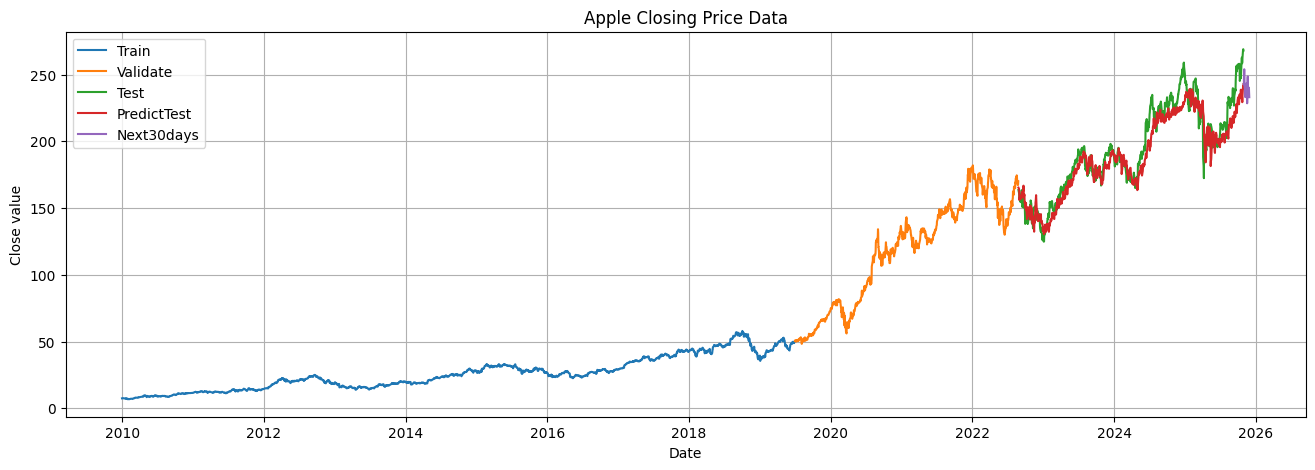

In [23]:
# Visualization
plt.figure(figsize=(16, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], test_data)
plt.plot(df.index[train_size + val_size : ], y_pred)

plt.plot(future_dates, prediction_next30_days)

plt.legend(['Train', 'Validate', 'Test', 'PredictTest', 'Next30days'])

plt.grid()
plt.title(f"Apple Closing Price Data")
plt.xlabel("Date")
plt.ylabel("Close value")
#plt.savefig('../Image/DNN_622_Apple.png')
plt.show()